
<left>
    <img src="http://epecora.com.br/DataFiles/PPGOLD_logo.png" width="300" alt="PPGOLD Data Science: INTRO"  />
</left>

# *Aula 08 - Data Science - PPGOLD*


---

* ## Classificação supervisionada
* ## Árvores de classificação
* ## Random Forests
* ## Case de distribuição de e-commerce



# DS08_1_tree



In [1]:
# check Python version
!python -V

import pandas as pd # download library to read data into dataframe
import numpy as np # import numpy library
import matplotlib.pyplot as plt # plots
import collections
import random # library for random number generation

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


file_path = "https://raw.githubusercontent.com/EduPek/PPGOLD7037/main/Data/Distribution_12k.csv"
starsData = pd.read_csv(file_path)

# fix name of the column displaying the Stars
column_names = starsData.columns.values
column_names[0] = "stars"
starsData.columns = column_names

starsData = starsData[starsData["stars"] <= 5]
starsData = starsData[starsData["stars"] >= 1]

starsData = starsData[starsData["FloorCD"] <= 4] # aproveitei e padronizei outros dados numéricos também
starsData = starsData[starsData["FloorCD"] >= 0]

starsData = starsData[starsData["RoutDeliveryOrder"] <= 6]
starsData = starsData[starsData["RoutDeliveryOrder"] >= 1]

starsData = starsData.reset_index(drop=True) # É importante refazer o indice do dataFrame, apeos excluir linhas, pois pode gerar problema no SciKit Learn


# import decision trees scikit-learn libraries
%matplotlib inline
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix # Não usaremos essas métricas neste exemplo
import matplotlib.pyplot as plt

#!conda install python-graphviz --yes
import graphviz
from sklearn.tree import export_graphviz
import itertools


# variáveis Dependentes e independentes the DataFrame
stars = starsData["stars"] # Só a coluna "stars"
stars_class = stars[:]
variables = starsData.iloc[:,1:] # Todas as outras colunas com excessão da "stars"


from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse= False)

prod_encoded = pd.DataFrame (enc.fit_transform(variables[['Product']])).astype(int)
prod_encoded.columns = enc.get_feature_names_out(['Product'])

origin_encoded = pd.DataFrame (enc.fit_transform(variables[['Origin']])).astype(int)
origin_encoded.columns = enc.get_feature_names_out(['Origin'])

CD_encoded = pd.DataFrame (enc.fit_transform(variables[['CD_name']])).astype(int)
CD_encoded.columns = enc.get_feature_names_out(['CD_name'])

Destination_encoded = pd.DataFrame (enc.fit_transform(variables[['Dest']])).astype(int)
Destination_encoded.columns = enc.get_feature_names_out(['Dest'])

TruckType_encoded = pd.DataFrame (enc.fit_transform(variables[['TruckType']])).astype(int)
TruckType_encoded.columns = enc.get_feature_names_out(['TruckType'])

TruckType2_encoded = pd.DataFrame (enc.fit_transform(variables[['TruckType2']])).astype(int)
TruckType2_encoded.columns = enc.get_feature_names_out(['TruckType2'])

DriverCD_C_encoded = pd.DataFrame (enc.fit_transform(variables[['DriverCD_C']])).astype(int)
DriverCD_C_encoded.columns = enc.get_feature_names_out(['DriverCD_C'])

var1 = pd.concat([prod_encoded, origin_encoded, CD_encoded, Destination_encoded, TruckType_encoded, TruckType2_encoded, DriverCD_C_encoded, variables["RoutDeliveryOrder"], variables["FloorCD"]], axis=1)

stars_class.loc[stars <= 2] = "bad"
stars_class.loc[stars == 3] = "average"
stars_class.loc[stars >= 4] = "good"

Python 3.9.7


# Separar os dados em Train e Test data



In [2]:
from sklearn.model_selection import train_test_split # Import train_test_split function

X_train, X_test, y_train, y_test = train_test_split(var1, stars_class, test_size=0.3) # 70% training and 30% test


## Modelo de classificação em árvores - Critério Gini

In [3]:
delivery_tree = tree.DecisionTreeClassifier(criterion="gini", max_depth = 25)
#delivery_tree = tree.DecisionTreeClassifier(criterion="gini", max_depth = 25, min_samples_split = 2, min_samples_leaf = 1)

delivery_tree.fit(X_train, y_train)

y_pred = delivery_tree.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.848303934871099


In [4]:
# Importância de cada feature
featureImp = pd.Series(delivery_tree.feature_importances_,index = X_train.columns).sort_values(ascending=False)

# Selecionar as mais importantes para mostrar
featureImp = featureImp[featureImp > 0.02]
print(featureImp)

RoutDeliveryOrder               0.108505
FloorCD                         0.098852
TruckType2_MiniVan              0.030369
Origin_F3                       0.030127
Origin_F4                       0.028700
TruckType2_CityDeliveryTruck    0.028410
TruckType2_Van                  0.023339
Origin_F1                       0.022579
Product_P11                     0.020582
Origin_F2                       0.020562
dtype: float64


## Modelo de classificação em árvores - Critério Entropia

para maiores detalhes da diferença entre o Gini e a Entropia ver [4]

In [5]:
delivery_tree_entropy = tree.DecisionTreeClassifier(criterion="entropy", max_depth = 25)
delivery_tree_entropy.fit(X_train, y_train)

y_pred_entr = delivery_tree_entropy.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_entr))

Accuracy: 0.8445047489823609


In [6]:
# Importância de cada feature
featureImp = pd.Series(delivery_tree_entropy.feature_importances_,index = X_train.columns).sort_values(ascending=False)

# Selecionar as mais importantes para mostrar
featureImp = featureImp[featureImp > 0.02]
print(featureImp)

RoutDeliveryOrder         0.114407
FloorCD                   0.104887
TruckType2_Van            0.036135
Origin_F1                 0.025195
TruckType_SemiTrailler    0.024238
TruckType2_MiniVan        0.023386
Origin_F3                 0.021056
dtype: float64


## Validando o modelo - Matriz de confusão

[[ 681  108   74]
 [  58 1197  127]
 [  42  164 1234]]


Text(0.5, 15.0, 'Predicted label')

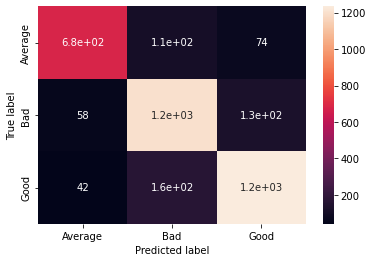

In [7]:
from sklearn.metrics import confusion_matrix

cf_Matrix = confusion_matrix(y_test, y_pred_entr)

print(cf_Matrix)

import seaborn as sns
sns.heatmap(cf_Matrix, annot=True, xticklabels = ["Average","Bad","Good"], yticklabels = ["Average","Bad","Good"])
plt.ylabel('True label')
plt.xlabel('Predicted label')


## Grid Search - Melhores parâmetros

In [8]:
from sklearn.model_selection import GridSearchCV

X, Y = X_train, y_train
tree_param = {'criterion':['gini','entropy'],'max_depth':[3,10,15,20,30,60,65,70,80,100,200,500]}
grid = GridSearchCV(tree.DecisionTreeClassifier(random_state= 100), tree_param, cv=5)
grid.fit(X, Y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 10, 15, 20, 30, 60, 65, 70, 80, 100,
                                       200, 500]})

In [9]:
print('The parameters combination that would give best accuracy are: ')
print(grid.best_params_)
print('The best accuracy achieved: ', grid.best_score_)

print(grid.best_params_['criterion'])

The parameters combination that would give best accuracy are: 
{'criterion': 'gini', 'max_depth': 60}
The best accuracy achieved:  0.9346209261739519
gini


In [10]:
delivery_tree_best = tree.DecisionTreeClassifier(criterion = grid.best_params_["criterion"], max_depth = grid.best_params_["max_depth"])
delivery_tree_best.fit(X_train, y_train)

y_pred = delivery_tree_best.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9636363636363636


[[ 832   16   15]
 [  24 1325   33]
 [  23   23 1394]]


Text(0.5, 15.0, 'Predicted label')

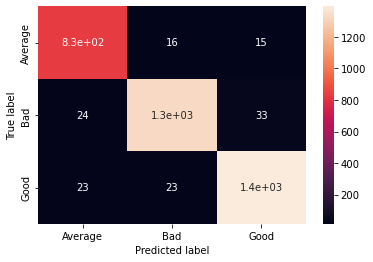

In [11]:
cf_Matrix = confusion_matrix(y_test, y_pred)

print(cf_Matrix)

import seaborn as sns
sns.heatmap(cf_Matrix, annot=True, xticklabels = ["Average","Bad","Good"], yticklabels = ["Average","Bad","Good"])
plt.ylabel('True label')
plt.xlabel('Predicted label')


# Random Forests

Accuracy: 0.9766621438263229
[[ 806   21   13]
 [  10 1342   11]
 [  11   20 1451]]


Text(0.5, 15.0, 'Predicted label')

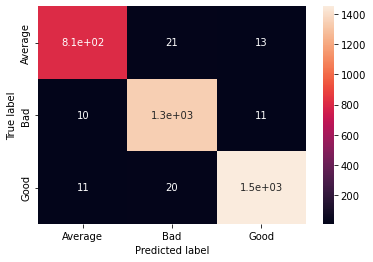

In [14]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(var1, stars_class, test_size=0.3) # 70% training and 30% test

rfc = RandomForestClassifier(n_estimators=1000, criterion=grid.best_params_['criterion'], max_depth=grid.best_params_['max_depth'])
rfc.fit(X_train,y_train)
y_pred=rfc.predict(X_test)

print("Accuracy:",accuracy_score(y_test, y_pred))

cf_Matrix = confusion_matrix(y_test, y_pred)

print(cf_Matrix)

sns.heatmap(cf_Matrix, annot=True, xticklabels = ["Average","Bad","Good"], yticklabels = ["Average","Bad","Good"])
plt.ylabel('True label')
plt.xlabel('Predicted label')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RoutDeliveryOrder               0.100958
FloorCD                         0.091514
TruckType2_Van                  0.030433
TruckType2_CityDeliveryTruck    0.027949
Origin_F2                       0.027108
Origin_F4                       0.026763
Origin_F3                       0.026751
Origin_F1                       0.025365
TruckType_Truck                 0.024212
TruckType_SemiTrailler          0.024114
TruckType2_MiniVan              0.022937
dtype: float64


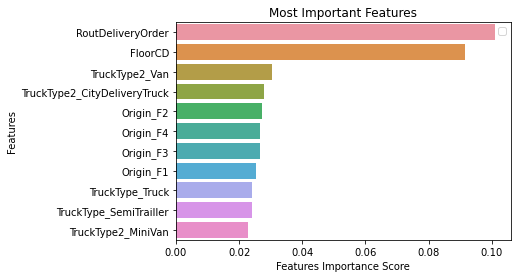

In [13]:
# Importância de cada feature
featureImp = pd.Series(rfc.feature_importances_,index = X_train.columns).sort_values(ascending=False)

# Selecionar as mais importantes para mostrar
featureImp = featureImp[featureImp > 0.02]
print(featureImp)

# Bar plot
sns.barplot(x=featureImp, y=featureImp.index)
plt.xlabel('Features Importance Score')
plt.ylabel('Features')
plt.title("Most Important Features")
plt.legend()
plt.show()


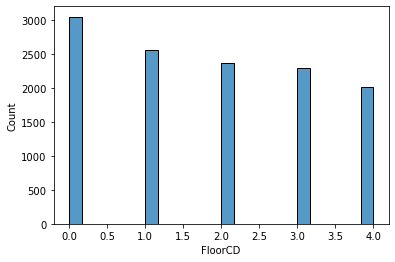

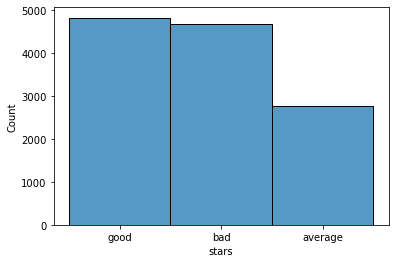

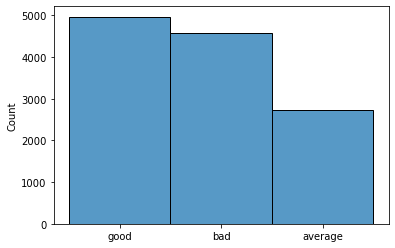

[[2672   40   57]
 [  50 4487  149]
 [  14   53 4759]]


Text(0.5, 15.0, 'Predicted label')

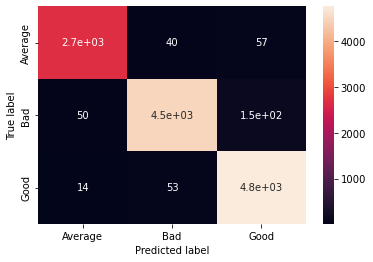

In [77]:
file_path = "https://raw.githubusercontent.com/EduPek/PPGOLD7037/main/Data/Distribution_12k.csv"
starsData = pd.read_csv(file_path)

# fix name of the column displaying the Stars
column_names = starsData.columns.values
column_names[0] = "stars"
starsData.columns = column_names

starsData = starsData[starsData["stars"] <= 5]
starsData = starsData[starsData["stars"] >= 1]

starsData = starsData[starsData["FloorCD"] <= 4] # aproveitei e padronizei outros dados numéricos também
starsData = starsData[starsData["FloorCD"] >= 0]

starsData.loc[(starsData["FloorCD"] == 4) & (starsData["Product"] == "P7"),"FloorCD"] = 0
starsData.loc[(starsData["FloorCD"] == 3) & (starsData["Product"] == "P7"),"FloorCD"] = 0

starsData.loc[(starsData["RoutDeliveryOrder"] == 6) & (starsData["Product"] == "P7"),"RoutDeliveryOrder"] = 1
starsData.loc[(starsData["RoutDeliveryOrder"] == 5) & (starsData["Product"] == "P7"),"RoutDeliveryOrder"] = 1


sns.histplot(starsData["FloorCD"])
plt.show()

starsData = starsData[starsData["RoutDeliveryOrder"] <= 6]
starsData = starsData[starsData["RoutDeliveryOrder"] >= 1]

starsData = starsData.reset_index(drop=True) # É importante refazer o indice do dataFrame, apeos excluir linhas, pois pode gerar problema no SciKit Learn

# variáveis Dependentes e independentes the DataFrame
stars = starsData["stars"] # Só a coluna "stars"
stars_class = stars[:]
variables = starsData.iloc[:,1:] # Todas as outras colunas com excessão da "stars"

enc = OneHotEncoder(handle_unknown='ignore', sparse= False)

prod_encoded = pd.DataFrame (enc.fit_transform(variables[['Product']])).astype(int)
prod_encoded.columns = enc.get_feature_names_out(['Product'])

origin_encoded = pd.DataFrame (enc.fit_transform(variables[['Origin']])).astype(int)
origin_encoded.columns = enc.get_feature_names_out(['Origin'])

CD_encoded = pd.DataFrame (enc.fit_transform(variables[['CD_name']])).astype(int)
CD_encoded.columns = enc.get_feature_names_out(['CD_name'])

Destination_encoded = pd.DataFrame (enc.fit_transform(variables[['Dest']])).astype(int)
Destination_encoded.columns = enc.get_feature_names_out(['Dest'])

TruckType_encoded = pd.DataFrame (enc.fit_transform(variables[['TruckType']])).astype(int)
TruckType_encoded.columns = enc.get_feature_names_out(['TruckType'])

TruckType2_encoded = pd.DataFrame (enc.fit_transform(variables[['TruckType2']])).astype(int)
TruckType2_encoded.columns = enc.get_feature_names_out(['TruckType2'])

DriverCD_C_encoded = pd.DataFrame (enc.fit_transform(variables[['DriverCD_C']])).astype(int)
DriverCD_C_encoded.columns = enc.get_feature_names_out(['DriverCD_C'])

var1 = pd.concat([prod_encoded, origin_encoded, CD_encoded, Destination_encoded, TruckType_encoded, TruckType2_encoded, DriverCD_C_encoded, variables["RoutDeliveryOrder"], variables["FloorCD"]], axis=1)

stars_class.loc[stars <= 2] = "bad"
stars_class.loc[stars == 3] = "average"
stars_class.loc[stars >= 4] = "good"

sns.histplot(stars_class)
plt.show()

y_pred=rfc.predict(var1)

sns.histplot(y_pred)
plt.show()

cf_Matrix = confusion_matrix(stars_class, y_pred)

print(cf_Matrix)

sns.heatmap(cf_Matrix, annot=True, xticklabels = ["Average","Bad","Good"], yticklabels = ["Average","Bad","Good"])
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [75]:
y_pred = pd.DataFrame(y_pred)
y_pred["class"] = "Predicted"
y_pred.columns = ["stars", "class"]

stars_class = pd.DataFrame(stars_class)
stars_class["class"] = "Original"

ff = pd.concat([y_pred,stars_class], axis =0)

ff.head()



,stars,class
0,good,Predicted
1,bad,Predicted
2,good,Predicted
3,bad,Predicted
4,good,Predicted


## Bibliografia

[1] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

[2] https://scikit-learn.org/stable/modules/cross_validation.html

[3] https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

[4] https://www.unine.ch/files/live/sites/imi/files/shared/documents/papers/Gini_index_fulltext.pdf

[5] https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

## Autor

<a href="https://www.linkedin.com/in/eduardopecora/" target="_blank">Eduardo Pecora</a>

## Log de modificações

| Data | Versão | Modificado por | Descrição |
| ----------------- | ------- | ---------- | ---------------------------------- |
| 03-10-2021       | 1.0     | Eduardo Pecora    | Criação               |

<hr>

